In [1]:
import os, math, csv, time, random

from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons, make_blobs, make_swiss_roll, make_s_curve

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial

from pyspark import RDD, SparkConf, SparkContext

In [2]:
def dist(p1, p2):
    """Euclidean distance."""
    sub = [a_i - b_i for a_i, b_i in zip(p1, p2)]
    return np.linalg.norm(sub,2)

# Coreset using k-means++ initialization

In [3]:
def k_means_plus_plus(pointset, k):
    """Sample centroids using kMeans++ initialization.
    
    Returns
      centroids:  list of coordinates.
      distances:  list of tuples (distance, closest center)
        of each point's closest center and the distance towards it.
      cost:  cost of the calculated initial clustering.
    """

    n = len(pointset)

    # for each point (distance, closest center)
    # distance to it's closest center, -1 means +infty
    distances = [(-1, None) for _ in range(n)]

    # cumulative sum of squared distances
    cumulative = [0 for _ in range(n)]
    
    def update(centroid, idx):
        # update the closest centers and distances
        for j in range(n):
            x = dist(centroid, pointset[j])
            if x < distances[j][0] or distances[j][0] == -1:
                distances[j] = (x, (centroid, idx))
        
        # compute cumulative sum of squared distances
        cumulative[0] = distances[0][0] * distances[0][0]
        for j in range(1, n):
            cumulative[j] = cumulative[j-1] + distances[j][0] * distances[j][0]

    # sample first centroid uniformly at random
    centroids = [pointset[random.randint(0, n-1)]]
            
    # sample remaining k-1 centroids
    for i in range(1, k):
        update(centroids[i-1], i-1)

        # sample next centroid using cumulative sum
        x = random.random() * cumulative[-1]

        if x <= cumulative[0]:
            centroids.append(pointset[0])
        else:
            for j in range(1,n):
                if cumulative[j-1] < x <= cumulative[j]:
                    centroids.append(pointset[j])               
    
    # make sure to update for last added centroid
    update(centroids[-1],len(centroids)-1)

    return centroids, distances, cumulative[-1]

In [4]:
points = np.random.rand(50, 2)
centroids, distances, cost = k_means_plus_plus(points, 5)

def _calculate_cost_brute(points, centroids):
    """For testing purposes."""
    total = 0
    for p in points:
        min_dist = -1
        for c in centroids:
            x = dist(p, c)
            if x < min_dist or min_dist == -1:
                min_dist = x
        
        total += min_dist * min_dist
    
    return total

assert _calculate_cost_brute(points, centroids) == cost

In [5]:
points = np.random.rand(50, 2)
k = 5

centroids, distances, cost = k_means_plus_plus(points, k)

kmeans = KMeans(n_clusters=k, random_state=0).fit(points)
X_label = kmeans.labels_
ball_center = kmeans.cluster_centers_
km_cost = kmeans.inertia_ # Inertia = squared sum

In [6]:
def coreset(pointset, k, eps = 0.1):
    X = list(pointset).copy()
    
    a = 1 # IDK waar die a vandaan komt, en welke waarde dat ie moet hebben
    d = 2 # dimensinality <--- holy shit ik zie deze typaids nu pas

    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    X_label = kmeans.labels_
    ball_center = kmeans.cluster_centers_
    cost = kmeans.inertia_ # Inertia = squared sum

    r = math.sqrt(cost/(a*len(X)*math.log(len(X))))
    coreset = []

    while len(X)>0:
        x = eps*r / math.sqrt(d)

        grids = []
        z = 2*math.ceil(r/x)
        # We have z*z cells per ball
        # Initialize array that stores grids
        for i in range(k):
            # We make the squares for each ball.
            grid = [ [0]*z for i in range(z)]
            grids.append(grid)  

        for idx, point in enumerate(X):
            ball = X_label[idx] # The ball closest to this point.
            c = ball_center[ball] # Centre of this ball
            if dist(point,c) <= r: # The point lies inside the ball
                grid = grids[ball] # The grid of this ball
                # compute the grid cell
                hor_idx = math.floor((point[0]-c[0])/x)+math.ceil(r/x)
                ver_idx = math.floor((point[1]-c[1])/x)+math.ceil(r/x)
                if grid[hor_idx][ver_idx] == 0:
                    # The cell is still empty, so we indicate that the cell is no longer empty
                    grid[hor_idx][ver_idx] = 1
                    coreset.append(point)
                # The point has now been assigned to a (non-empty) cell so we can remove it from X and forget about it.
                X.pop(idx)
        #Double r for  next iteration.
        r = r*2
    return coreset

In [7]:
def coreset_plus_plus(pointset, k, eps = 0.1):
    centroids, distances, cost = k_means_plus_plus(pointset, k)
    
    a = 1 # parameter used for approximation of OPT
    d = 2 # dimensinality
    
    n = len(pointset)
    r = math.sqrt(cost / (a * n * math.log(n)))

    coreset = []
    
    

    # (p, (dist. to closest c, (coord's of closest c, index of closest c)))
    X = list(zip(pointset, distances))
    todo_list = [True for _ in X] # True means we still need to handle this point.
    
    
    while True in todo_list:
        x = eps * r / math.sqrt(d)

        grids = []
        #print(r,x,r/x)
        z = 2 * math.ceil(r/x)

        # We have z*z cells per ball
        # Initialize array that stores grids
        for i in range(k):
            # We make the squares for each ball.
            grid = [ [0]*z for i in range(z) ]
            grids.append(grid)
        
        # TODO:     
        for idx, (p, (d, (c_coo, c_idx))) in enumerate(X):
            if todo_list[idx]:
                if d <= r: # p lies inside the ball
                    grid = grids[c_idx] # grid of this ball

                    # compute the grid cell
                    hor_idx = math.floor((p[0]-c_coo[0])/x)+math.ceil(r/x)
                    ver_idx = math.floor((p[1]-c_coo[1])/x)+math.ceil(r/x)
                    if grid[hor_idx][ver_idx] == 0:
                        # The cell is still empty, so we indicate that the cell is no longer empty
                        grid[hor_idx][ver_idx] = 1
                        coreset.append(p)

                    # The point has now been assigned to a (non-empty) cell so we can remove it from X and forget about it.
                    todo_list[idx] = False

        r = r*2

    return coreset

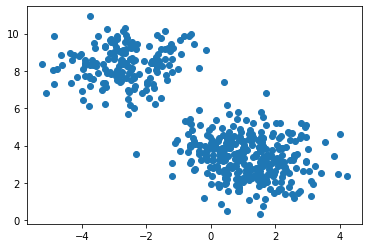

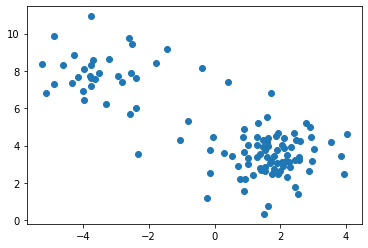

In [8]:
#X = list(np.random.rand(5000, 2))
X = list(make_blobs(n_samples=500)[0])

res = coreset_plus_plus(X, 3, 0.5)



plt.scatter(np.array(X)[:,0],np.array(X)[:,1])
plt.show()
plt.scatter(np.array(res)[:,0],np.array(res)[:,1])
plt.show()

# The parrallel stuff

In [9]:
conf = SparkConf().setAppName('Coreset')
sc = SparkContext.getOrCreate(conf=conf)


# This performs the action of going up one layer in the tree from the lectures,
# we give every partion an id, divide it by two such that two partitions share the same key.
# Then we group by the key. This halves the number of partitions. Then we throw away the keys and 
# we apply the flatmap to obtain one collection of points.
def mergeLayer(rdd):
    size = math.ceil(rdd.getNumPartitions()/2)
    return rdd.mapPartitionsWithIndex(lambda idx, a:  [(math.floor(idx/2),l) for l in a]).groupByKey(size).values().flatMap(list)


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/13 17:19:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/01/13 17:20:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [10]:
k = 3
eps = 0.2

X = list(make_blobs(n_samples=500000)[0])
machines = math.floor(math.sqrt(len(X)))
print(machines)

start_time = time.time()
RDD = sc.parallelize(X, machines)

partitions = RDD.getNumPartitions()
while partitions > 1:
    RDD = RDD.mapPartitions(lambda points : coreset(points,k,eps))
    RDD = mergeLayer(RDD)
    partitions = RDD.getNumPartitions()
    
res = coreset_plus_plus(RDD.collect(),k,eps)
end_time = time.time()

print("time taken", end_time-start_time)

707


time taken 107.70225119590759


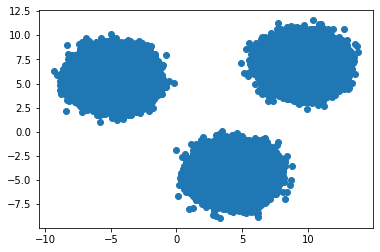

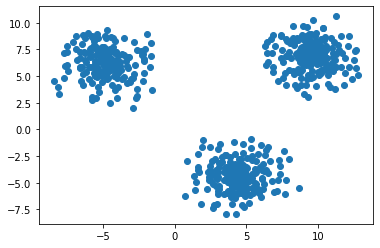

In [11]:
plt.scatter(np.array(X)[:,0],np.array(X)[:,1])
plt.show()
plt.scatter(np.array(res)[:,0],np.array(res)[:,1])
plt.show()